### NMR shieldings
* molecule from sdf
* calculation of anisotropic shielding
* GPU Version



XYZ-file xyz/id6731.xyz succesful.
File exist.
file "bilder/id6731_g.png" not exist.


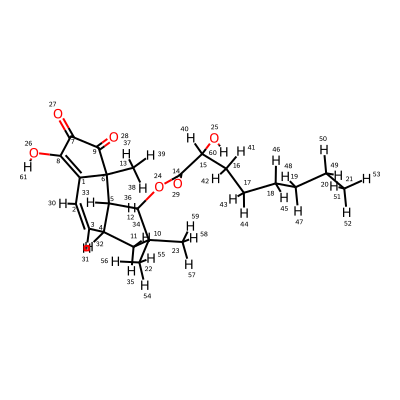

Start Calculation
output file: logs/id6731_gpu.log


/home/sthomas/.conda/envs/mycuda11neu/lib/python3.12/site-packages/pyscf/dft/libxc.py:512: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Walltime: 286.54611587524414 seconds
can be continued!


In [2]:
#####################################
#
# Computing NMR shielding constants
#
######################################
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image, display
import pyscf
import gpu4pyscf
from gpu4pyscf import dft
from gpu4pyscf.properties.shielding import eval_shielding
from pathlib import Path
import sys,time,os

######## ID of entry in sdf ###############

eintrags_id = 6731
jobname = f"id{eintrags_id}"

# build filenames
xyzin =f"xyz/{jobname}.xyz"
logfile=f"logs/{jobname}_gpu.log"
bilddatei=f"bilder/{jobname}_g.png"


###  SDF file ###

mols = Chem.SDMolSupplier("../nmrdata/NMR8K.sdf")


size=(400,400)   # size of picture
molin=mols[eintrags_id]


# generate 3D Coordinates using Universal Force Field
molin = Chem.AddHs(molin)  # Add hydrogen
AllChem.EmbedMolecule(molin)  # 3D-Embedding
AllChem.UFFOptimizeMolecule(molin)  # Optimisation

# save XYZ-file
Chem.MolToXYZFile(molin, xyzin)
print(f"XYZ-file {xyzin} succesful.")

dateipfad = Path(xyzin)

if dateipfad.exists():
    print("File exist.")
else:
    print("file not exist.")
    sys.exit(1)

if molin is not None:  
    # Generate image file and delete it beforehand if it exists; 
    # check if the file exists, and if so, delete it.
    if os.path.isfile(bilddatei):
        print(f'file "{bilddatei}" exist.')
    
        # Datei löschen
        os.remove(bilddatei)
        print(f'file "{bilddatei}" deleted.')
    else:
        print(f'file "{bilddatei}" not exist.')
    
    for atom in molin.GetAtoms():
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", str(atom.GetIdx()+1))
    image= Chem.Draw.MolToImage(molin, size=size)
    image.save(bilddatei)
    properties = molin.GetPropsAsDict()  #Read all properties stored in the SDF file.

display(image)
print("Start Calculation")

start_time = time.time()
mol = pyscf.M(atom=xyzin, basis='6-31g*', output=logfile)
mf = dft.RKS(mol)
mf.xc = 'b3lyp'
mf.kernel()
tensor = eval_shielding(mf)

abschirmung = tensor[0].get()+tensor[1].get()
end_time = time.time()
print(f'Walltime: {end_time-start_time} seconds')
print("can be continued!")

In [3]:
#################################################################################################
#
# Constants for shioelding calculation
#
# CSHESHIRE Repository (Tantillo)
#
# Table 1a,1b and 1c w
#
# 1a without solvent, 1b and 1c with solvent
#
# delta = (intercept -sigma)/ - slope
#
# The sign of the slope is immediately incorporated into the definition of the constant.
#
# TMS shielding from my calculation delta = sigma - TMS
#
##################################################################################################

intercept1a = 187.4743
slope1a = 0.9269
intercept1b = 188.4418
slope1b = 0.9449
intercept1c = 188.01
slope1c = 0.9378
tmsshield = 190.2218


shift = [0] *mol.natm
shift1a = [0] *mol.natm
shift1b= [0] *mol.natm
shift1c= [0] *mol.natm
shifttms= [0] *mol.natm


data = []
for i in range(mol.natm):
    shift[i]= (abschirmung[i,0,0] + abschirmung[i,1,1] + abschirmung[i,2,2])/3
    #print(f"Atom {mol._atom[i][0]} {i} hat eine totale Abschirmung von {shift[i]} .")

    if  mol._atom[i][0] =='C':
        shift1a[i] = (intercept1a-shift[i])/slope1a
        shift1b[i] = (intercept1b-shift[i])/slope1b
        shift1c[i] = (intercept1c-shift[i])/slope1c
        shifttms[i] = tmsshield - shift[i]
        data.append({'Atom': mol._atom[i][0], 'Index': i+1, 'Totale shielding': shift[i], 'table1a': shift1a[i], 'table1b' : shift1b[i], 'table1c' : shift1c[i], 'TMS' : shifttms[i]})

print("continue")

continue


In [4]:
import pandas as pd
from IPython.display import display, HTML
# Erstelle ein DataFrame
df = pd.DataFrame(data)

# Setze die Spaltenüberschriften
df.columns = ['Atom', 'Index', 'Totale shielding', 'table1a', 'table1b', 'table1c', 'TMS']

# Verwende Styler, um die Schriftgröße zu ändern
styled_df = df.style.set_table_attributes('style="font-size: 17px;"')  # Ändere die Schriftgröße hier

# Zeige die Tabelle an
display(HTML(f"<h2 style=color:#069>{jobname}</h2>"))
display(styled_df)

# Zeige die Tabelle an

,Atom,Index,Totale shielding,table1a,table1b,table1c,TMS
0,C,1,47.474255,151.041153,149.187792,149.856840,142.747545
1,C,2,76.786330,119.417380,118.166441,118.600629,113.435470
2,C,3,54.242410,143.739228,142.024966,142.639785,135.979390
3,C,4,145.336435,45.461069,45.618970,45.503908,44.885365
4,C,5,139.881018,51.346728,51.392509,51.321158,50.340782
5,C,6,145.677508,45.093097,45.258008,45.140213,44.544292
6,C,7,14.380873,186.744446,184.210951,185.145156,175.840927
7,C,8,42.278082,156.647123,154.686970,155.397652,147.943718
8,C,9,-12.972765,216.255330,213.159662,214.313036,203.194565
9,C,10,144.665623,46.184784,46.328899,46.219212,45.556177


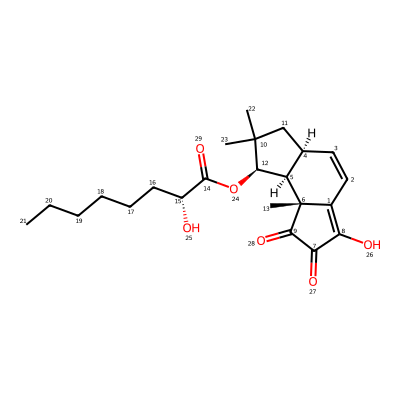

In [5]:
d2mol=Chem.MolFromXYZFile(xyzin)
# Automatically determine bonds
rdDetermineBonds.DetermineBonds(d2mol)
for d2atom in d2mol.GetAtoms():
        # For each atom, set the property "atomNote" to a index+1 of the atom
        d2atom.SetProp("atomNote", str(d2atom.GetIdx()+1))

d2mol=Chem.RemoveHs(d2mol)
# 2D-coordinates
AllChem.Compute2DCoords(d2mol)
# draw molecule
img = Draw.MolToImage(d2mol,size=size)
display(img)

In [6]:
size=(600,600) # Größe der Molekülabbildung
Chem.Draw.IPythonConsole.drawMol3D(molin,drawAs='stick', bgColor='yellow', size=size) #sphere anstelle stick funktioniert auch

3Dmol.js failed to load for some reason. Please check your browser console for error messages.